In [43]:
# Enable in-notebook generation of plots
%matplotlib inline

# Experiments collected data

Data required to run this notebook are available for download at this link:

https://www.dropbox.com/s/q9ulf3pusu0uzss/SchedTuneAnalysis.tar.xz?dl=0

This archive has to be extracted from within the LISA's results folder.

## Initial set of data

In [2]:
res_dir = '../../results/SchedTuneAnalysis/'
!tree {res_dir}

../../results/SchedTuneAnalysis/
├── boost15_cluster_freqs.png
├── boost15_task_util_task_ramp.png
├── energy.json
├── output.log
├── platform.json
├── rt-app-task_ramp-0.log
├── test_00.json
├── trace_boost15.dat
├── trace_boost15.raw.txt
├── trace_boost15.txt
├── trace_boost25.dat
└── trace_noboost.dat

0 directories, 12 files


In [3]:
noboost_trace = res_dir + 'trace_noboost.dat'
boost15_trace = res_dir + 'trace_boost15.dat'
boost25_trace = res_dir + 'trace_boost25.dat'

# trace_file = noboost_trace
trace_file = boost15_trace
# trace_file = boost25_trace

## Loading support data collected from the target

In [5]:
import json

# Load the platform information
with open('../../results/SchedTuneAnalysis/platform.json', 'r') as fh:
    platform = json.load(fh)
print "Platform descriptio collected from the target:"
print json.dumps(platform, indent=4)

Platform descriptio collected from the target:
{
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 64
            }, 
            "cpu": {
                "cap_max": 1024, 
                "nrg_max": 616
            }
        }, 
        "little": {
            "cluster": {
                "nrg_max": 57
            }, 
            "cpu": {
                "cap_max": 447, 
                "nrg_max": 93
            }
        }
    }, 
    "clusters": {
        "big": [
            1, 
            2
        ], 
        "little": [
            0, 
            3, 
            4, 
            5
        ]
    }, 
    "cpus_count": 6, 
    "freqs": {
        "big": [
            450000, 
            625000, 
            800000, 
            950000, 
            1100000
        ], 
        "little": [
            450000, 
            575000, 
            700000, 
            775000, 
            850000
        ]
    }, 
    "topology": [
        [
         

In [6]:
from trappy.stats.Topology import Topology

# Create a topology descriptor
topology = Topology(platform['topology'])

# Trace analysis

We want to ensure that the task has the expected workload:<br>
- LITTLE CPU bandwidth of **[10, 35 and 60]%** every **2[ms]**
- activations every **32ms**
- always **starts on a big** core

## Trace inspection

### Using kernelshark

In [7]:
# Let's look at the trace using kernelshark...
!kernelshark {trace_file} 2>/dev/null

version = 6


- Requires a lot of interactions and hand made measurements
- We cannot easily annotate our findings to produre a sharable notebook

### Using the TRAPpy Trace Plotter

An overall view on the trace is still useful to get a graps on what we are looking at.

In [10]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(trace_file)#, execnames="task_ramp")#, pids=[2221])

## Events Plotting

The **sched_load_avg_task** trace events reports this information

### Using all the unix arsenal to parse and filter the trace

In [8]:
# Get a list of first 5 "sched_load_avg_events" events
sched_load_avg_events = !(\
    grep sched_load_avg_task {trace_file.replace('.dat', '.txt')} | \
    head -n5 \
)
 
print "First 5 sched_load_avg events:"
for line in sched_load_avg_events:
    print line

First 5 sched_load_avg events:
       trace-cmd-2204  [000]  1773.509207: sched_load_avg_task:  comm=trace-cmd pid=2204 cpu=0 load_avg=452 util_avg=176 util_est=176 load_sum=21607277 util_sum=8446887 period_contrib=125
       trace-cmd-2204  [000]  1773.509223: sched_load_avg_task:  comm=trace-cmd pid=2204 cpu=0 load_avg=452 util_avg=176 util_est=176 load_sum=21607277 util_sum=8446887 period_contrib=125
          <idle>-0     [002]  1773.509522: sched_load_avg_task:  comm=sudo pid=2203 cpu=2 load_avg=0 util_avg=0 util_est=941 load_sum=7 util_sum=7 period_contrib=576
            sudo-2203  [002]  1773.511197: sched_load_avg_task:  comm=sudo pid=2203 cpu=2 load_avg=14 util_avg=14 util_est=941 load_sum=688425 util_sum=688425 period_contrib=219
            sudo-2203  [002]  1773.511219: sched_load_avg_task:  comm=sudo pid=2203 cpu=2 load_avg=14 util_avg=14 util_est=14 load_sum=688425 util_sum=688425 period_contrib=219
grep: write error


A graphical representation whould be really usefuly!

### Using TRAPpy generated DataFrames

#### Generate DataFrames from Trace Events

In [11]:
# Load the LISA::Trace parsing module
from trace import Trace

# Define which event we are interested into
trace = Trace(trace_file, [
            "sched_switch",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_boost_cpu",
            "sched_boost_task",
            "cpu_frequency",
            "cpu_capacity",
    ], platform)

#### Get the DataFrames for the events of interest

In [12]:
# Trace events are converted into tables, let's have a look at one
# of such tables
load_df = trace.data_frame.trace_event('sched_load_avg_task')
load_df.head()

,__comm,__cpu,__pid,comm,cpu,load_avg,load_sum,period_contrib,pid,util_avg,util_est,util_sum,cluster
Time,,,,,,,,,,,,,
0.000065,trace-cmd,0,2204,trace-cmd,0,452,21607277,125,2204,176,176,8446887,LITTLE
0.000081,trace-cmd,0,2204,trace-cmd,0,452,21607277,125,2204,176,176,8446887,LITTLE
0.000380,<idle>,2,0,sudo,2,0,7,576,2203,0,941,7,big
0.002055,sudo,2,2203,sudo,2,14,688425,219,2203,14,941,688425,big
0.002077,sudo,2,2203,sudo,2,14,688425,219,2203,14,14,688425,big


In [14]:
df = load_df[load_df.comm.str.match('k.*')]
# df.head()
print df.comm.unique()

['kworker/u12:0' 'kworker/5:0' 'kworker/2:1' 'kworker/1:1' 'kworker/0:1'
 'ksoftirqd/0' 'kworker/3:1' 'kworker/4:1' 'ksoftirqd/5' 'kworker/5:1H'
 'ksoftirqd/2' 'ksoftirqd/1' 'kworker/2:2' 'kthreadd' 'kworker/2:0'
 'kworker/u12:2']


In [15]:
cap_df = trace.data_frame.trace_event('cpu_capacity')
cap_df.head()

,__comm,__cpu,__pid,cpu,capacity,max_capacity,tip_capacity
Time,,,,,,,
0.002708,kschedfreq:0,4,1489,0,236,447,357.6
0.002710,kschedfreq:0,4,1489,3,236,447,357.6
0.002711,kschedfreq:0,4,1489,4,236,447,357.6
0.002712,kschedfreq:0,4,1489,5,236,447,357.6
0.410816,kschedfreq:1,2,1490,1,1024,1024,819.2


#### Plot the signals of interest

In [20]:
# Signals can be easily plot using the ILinePlotter
trappy.ILinePlot(
    
    # FTrace object
    trace.ftrace,
    
    # Signals to be plotted
    signals=[
      'cpu_capacity:capacity',
      'sched_load_avg_task:util_avg'
    ],
    
    # Generate one plot for each value of the specified column
     pivot='cpu',
    
    # Generate only plots which satisfy these filters
    filters={
        'comm': ['task_ramp'],
        'cpu' : [2,5]
    },
    
    # Formatting style
    per_line=2,
    drawstyle='steps-post',
    marker = '+',
    
    sync_zoom=True,
    group="GroupTag"

).view()

,
,


### Use a set of standard plots

A graphical representation can always be on hand

In [21]:
trace = Trace(boost15_trace,
              ["sched_switch",
               "sched_overutilized",
               "sched_load_avg_cpu",
               "sched_load_avg_task",
               "sched_boost_cpu",
               "sched_boost_task",
               "cpu_frequency",
               "cpu_capacity",
              ],
              platform,
              plots_prefix='boost15_'
             )

Usually a common set of plots can be generated which capture the most useful information realted to a workload we are analysing

#### Example of task realted signals

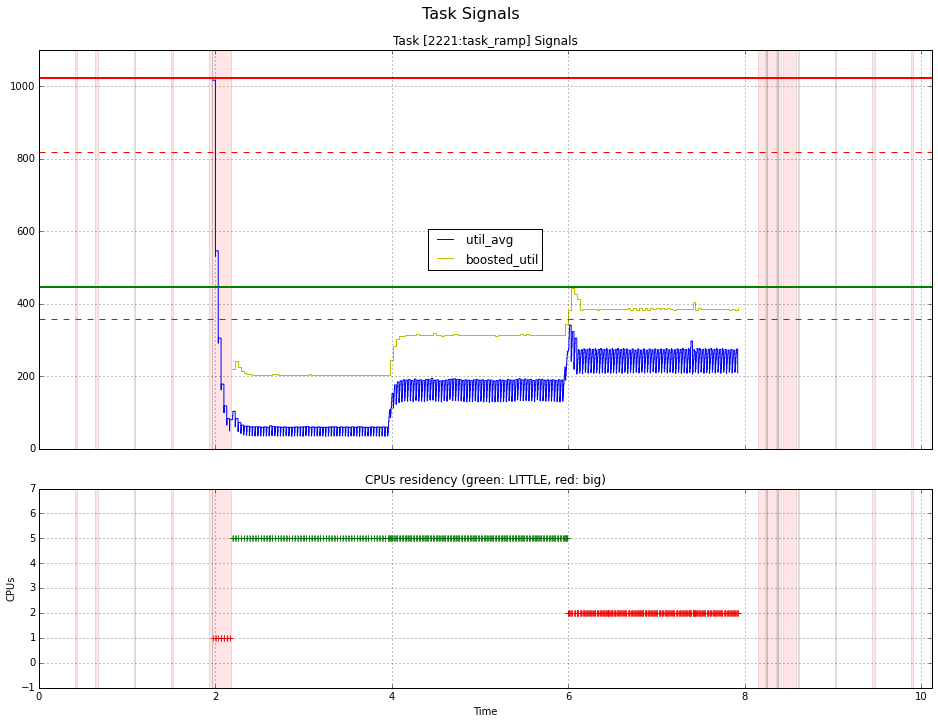

In [130]:
trace.analysis.tasks.plotTasks(
    tasks=['task_ramp'],
    signals=['util_avg', 'boosted_util', 'sched_overutilized', 'residencies'],
)

#### Example of Clusters related singals

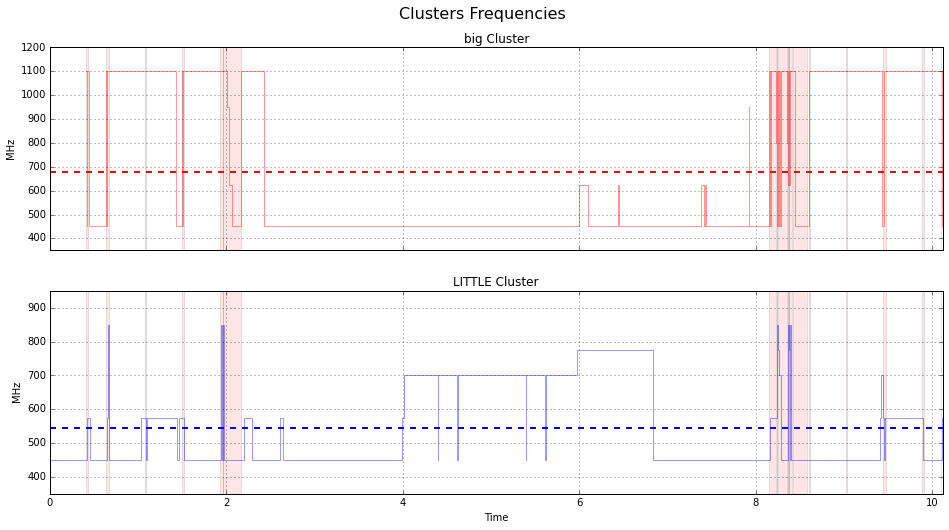

In [131]:
trace.analysis.frequency.plotClusterFrequencies()

#### Take-away

In a single plot we can aggregate multiple informations which makes it easy to verify the expected behaviros.

With a set of properly defined plots we are able to condense mucy more sensible information which are easy to ready because they are "standard".<br>
We immediately capture what we are interested to evaluate!

Moreover, all he produced plots are available as high resolution images, ready to be shared and/or used in other reports.

In [132]:
!tree {res_dir}

../../results/SchedTuneAnalysis/
├── boost15_cluster_freqs.png
├── boost15_task_util_task_ramp.png
├── energy.json
├── output.log
├── platform.json
├── rt-app-task_ramp-0.log
├── test_00.json
├── trace_boost15.dat
├── trace_boost15.raw.txt
├── trace_boost15.txt
├── trace_boost25.dat
├── trace_boost25.raw.txt
├── trace_boost25.txt
├── trace.dat
├── trace_noboost.dat
├── trace_noboost.raw.txt
├── trace_noboost.txt
├── trace.raw.txt
└── trace.txt

0 directories, 19 files


## Behavioral Analysis

### Is the task starting on a big core?

We always expect a new task to be allocated on a big core.

To verify this condition we need to know what is the topology of the target.

This information is **automatically collected by LISA** when the workload is executed.<br>
Thus it can be used to write **portable tests** conditions.

#### Create a SchedAssert for the specific topology

In [23]:
from bart.sched.SchedMultiAssert import SchedAssert

# Create an object to get/assert scheduling pbehaviors
sa = SchedAssert(trace_file, topology,  execname='task_ramp')

#### Use the SchedAssert method to investigate properties of this task

In [28]:
# Check on which CPU the task start its execution
if sa.assertFirstCpu(platform['clusters']['big']):#, window=(4,6)):
    print "PASS: Task starts on big CPU: ", sa.getFirstCpu()
else:
    print "FAIL: Task does NOT start on a big CPU!!!"

PASS: Task starts on big CPU:  1


### Is the task generating the expected load?

We expect 35% load in the between 2 and 4 [s] of the execution

#### Identify the start of the first phase

In [29]:
# Let's find when the task starts
start = sa.getStartTime()
first_phase = (start, start+2)

print "The task starts execution at [s]: ", start
print "Window of interest: ", first_phase

The task starts execution at [s]:  1.9683
Window of interest:  (1.9682999999999993, 3.9682999999999993)


#### Use the SchedAssert module to check the task load in that period

In [30]:
import operator

# Check the task duty cycle in the second step window
if sa.assertDutyCycle(10, operator.lt, window=first_phase):
    print "PASS: Task duty-cycle is {}% in the [2,4] execution window"\
          .format(sa.getDutyCycle(first_phase))
else:
    print "FAIL: Task duty-cycle is {}% in the [2,4] execution window"\
          .format(sa.getDutyCycle(first_phase))

FAIL: Task duty-cycle is 18.11125% in the [2,4] execution window


This test fails because we have not considered a scaling factor due running at a lower OPP.

To write a portable test we need to account for that condition!

#### Take OPP scaling into consideration

In [31]:
# Get LITTLEs capacities ranges:
littles = platform['clusters']['little']
little_capacities = cap_df[cap_df.cpu.isin(littles)].capacity
min_cap = little_capacities.min()
max_cap = little_capacities.max()
print "LITTLEs capacities range: ", (min_cap, max_cap)

# Get min OPP correction factor
min_little_scale = 1.0 * min_cap / max_cap
print "LITTLE's min capacity scale: ", min_little_scale

LITTLEs capacities range:  (236, 447)
LITTLE's min capacity scale:  0.527964205817


In [33]:
# Scale the target duty-cycle according to the min OPP
target_dutycycle = 10 / min_little_scale
print "Scaled target duty-cycle: ", target_dutycycle


target_dutycycle = 1.01 * target_dutycycle

print "1% tolerance scaled duty-cycle: ", target_dutycycle

Scaled target duty-cycle:  18.9406779661
1% tolerance scaled duty-cycle:  19.1300847458


#### Write a more portable assertion

In [34]:
# Add a 1% tolerance to our scaled target dutycycle
if sa.assertDutyCycle(1.01 * target_dutycycle, operator.lt, window=first_phase):
    print "PASS: Task duty-cycle is {}% in the [2,4] execution window"\
          .format(sa.getDutyCycle(first_phase) * min_little_scale)
else:
    print "FAIL: Task duty-cycle is {}% in the [2,4] execution window"\
          .format(sa.getDutyCycle(first_phase) * min_little_scale)

PASS: Task duty-cycle is 9.56209172258% in the [2,4] execution window


### Is the task migrated once we exceed the LITTLE CPUs capacity?

#### Check that the task is switching the cluster once expected

In [35]:
# Consider a 100 [ms] window for the task to migrate
delta = 0.1

# Defined the window of interest
switch_window=(start+4-delta, start+4+delta)

if sa.assertSwitch("cluster",
             platform['clusters']['little'],
             platform['clusters']['big'],
             window=switch_window):
    print "PASS: Task switches to big within: ", switch_window
else:
    print "PASS: Task DOES NO switches to big within: ", switch_window

PASS: Task switches to big within:  (5.8682999999999996, 6.0682999999999989)


#### Check that the task is running most of its time on the LITTLE cluster

In [36]:
import operator

if sa.assertResidency("cluster", platform['clusters']['little'], 66, operator.le, percent=True):
    print "PASS: Task exectuion on LITTLEs is {:.1f}% (less than 66% of its execution time)".\
        format(sa.getResidency("cluster", platform['clusters']['little'], percent=True))
else:
    print "FAIL: Task run on LITTLE for MORE than 66% of its execution time"

PASS: Task exectuion on LITTLEs is 53.1% (less than 66% of its execution time)


### Check that the util estimation is properly computed and CPU capacity matches

In [7]:
start = 2
last_phase = (start+4, start+6)

analyzer_config = {
    "SCALE" : 1024,
    "BOOST" : 15,
}

# Verify that the margin is properly computed for each event:
# margin := (scale - util) * boost
margin_check_statement = "(((SCALE - sched_boost_task:util) * BOOST) // 100) == sched_boost_task:margin"

In [8]:
from bart.common.Analyzer import Analyzer

# Create an Assertion Object
a = Analyzer(trace.ftrace,
             analyzer_config,
             window=last_phase,
             filters={"comm": "task_ramp"})

In [9]:
if a.assertStatement(margin_check_statement):
    print "PASS: Margin properly computed in : ", last_phase
else:
    print "FAIL: Margin NOT properly computed in : ", last_phase

PASS: Margin properly computed in :  (6, 8)


#### Check that the CPU capacity matches the task boosted value

In [10]:
# Get the two dataset of interest
df1 = trace.data_frame.trace_event('cpu_capacity')[['cpu', 'capacity']]
df2 = trace.data_frame.trace_event('boost_task_rtapp')[['__cpu', 'boosted_util']]

# Join the information from these two
df3 = df2.join(df1, how='outer')
df3 = df3.fillna(method='ffill')
df3 = df3[df3.__cpu == df3.cpu]
#df3.ix[start+4:start+6,].head()

In [11]:
len(df3[df3.boosted_util >= df3.capacity])

19

##### Do it the TRAPpy way

In [12]:
# Create the TRAPpy class
trace.ftrace.add_parsed_event('rtapp_capacity_check', df3)
# Define pivoting value
trace.ftrace.rtapp_capacity_check.pivot = 'cpu'

# Create an Assertion
a = Analyzer(trace.ftrace,
             {"CAP" : trace.ftrace.rtapp_capacity_check},
             window=(start+4.1, start+6))
a.assertStatement("CAP:capacity >= CAP:boosted_util")

True

## Going further on events processing

### What are the relative residency on different OPPs?

We are not limited to the usage of pre-defined functions. We can exploit the full power of PANDAS to process the DataFrames to extract all kind of information we want.

#### Use PANDAs APIs to filter and aggregate events

In [40]:
import pandas as pd

# Focus on cpu_frequency events for CPU0
df = trace.data_frame.trace_event('cpu_frequency')
df = df[df.cpu == 0]

# Compute the residency on each OPP before switching to the next one
df.loc[:,'start'] = df.index
df.loc[:,'delta'] = (df['start'] - df['start'].shift()).fillna(0).shift(-1)

# Group by frequency and sum-up the deltas
freq_residencies = df.groupby('frequency')['delta'].sum()
print "Residency time per OPP:"
df = pd.DataFrame(freq_residencies)

df.head()

# Compute the relative residency time
tot = sum(freq_residencies)
#df = df.apply(lambda delta : 100*delta/tot)
for f in freq_residencies.index:
    print "Freq {:10d}Hz : {:5.1f}%".format(f, 100*freq_residencies[f]/tot)

Residency time per OPP:
Freq     450000Hz :  59.3%
Freq     575000Hz :  11.7%
Freq     700000Hz :  19.5%
Freq     775000Hz :   8.8%
Freq     850000Hz :   0.6%


#### Use MathPlot Lib to generate all kind of plot from collected data

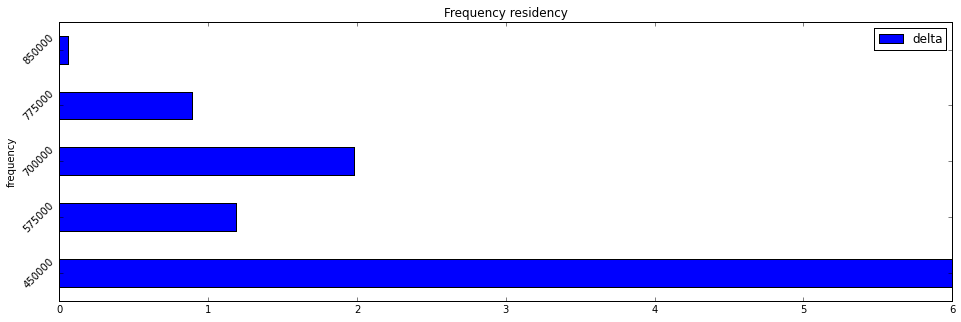

In [44]:
# Plot residency time
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(16, 5));
df.plot(kind='barh', ax=axes, title="Frequency residency", rot=45);

<br><br><br><br>
Advanced DataFrame usage: filtering by columns/rows, merging tables, plotting data<br>
[notebooks/tutorial/05_TrappyUsage.ipynb](05_TrappyUsage.ipynb)
<br><br><br><br>

# Remote target connection and control

Using LISA APIs to control a remote device and run custom workloads

## Configure the connection

In [ ]:
# Setup a target configuration
conf = {
    
    # Target is localhost
    "platform"    : 'linux',
    "board"       : "juno",
    
    # Login credentials
    "host"        : "192.168.0.1",
    "username"    : "root",
    "password"    : "",

    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
       "0": 355, "1": 138, "2": 138, "3": 355, "4": 354, "5": 354
    },
    
    # FTrace events end buffer configuration
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_contrib_scale_f",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_boostgroup_update",
            "sched_tune_filter",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_energy_diff",
            "cpu_frequency",
            "cpu_capacity",
         ],
         "buffsize" : 10240
    },

    # Where results are collected
    "results_dir" : "SchedTuneAnalysis",

    # Devlib module required (or not required)
    'modules' : [ "cpufreq", "cgroups" ],
    #"exclude_modules" : [ "hwmon" ],
}

## Setup the connection

In [ ]:
# Support to access the remote target
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(conf)
target = te.target

print "DONE"

## Target control

### Run custom commands

In [ ]:
# Enable Energy-Aware scheduler
target.execute("echo ENERGY_AWARE > /sys/kernel/debug/sched_features");
target.execute("echo UTIL_EST > /sys/kernel/debug/sched_features");

# Check which sched_feature are enabled
sched_features = target.read_value("/sys/kernel/debug/sched_features");
print "sched_features:"
print sched_features

### Example CPUFreq configuration

In [ ]:
target.cpufreq.set_all_governors('sched');

# Check which governor is enabled on each CPU
enabled_governors =  target.cpufreq.get_all_governors()
print enabled_governors

### Example of CGruops configuration

In [ ]:
schedtune = target.cgroups.controller('schedtune')

# Configure a 50% boostgroup
boostgroup = schedtune.cgroup('/boosted')
boostgroup.set(boost=25)

# Dump the configuraiton of each groups
cgroups = schedtune.list_all()
for cgname in cgroups:
    cgroup = schedtune.cgroup(cgname)
    attrs = cgroup.get()
    boost = attrs['boost']
    print '{}:{:<15} boost: {}'.format(schedtune.kind, cgroup.name, boost)

# Remote workloads execution

## Generate RTApp configurations

In [ ]:
# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'test', calibration=te.calibration())

# Ramp workload
ramp = Ramp(
    start_pct=10,
    end_pct=60,
    delta_pct=25,
    time_s=2,
    period_ms=32
)

# Configure this RTApp instance to:
rtapp.conf(

    # 1. generate a "profile based" set of tasks
    kind = 'profile',
    
    # 2. define the "profile" of each task
    params = {
        
        # 3. Composed task
        'task_ramp': ramp.get(),
    },
    
    #loadref='big',
    loadref='LITTLE',
    run_dir=target.working_directory
    
);

## Execution and tracing

In [ ]:
def execute(te, wload, res_dir, cg='/'):
    
    logging.info('# Setup FTrace')
    te.ftrace.start()

    if te.emeter:
        logging.info('## Start energy sampling')
        te.emeter.reset()

    logging.info('### Start RTApp execution')
    wload.run(out_dir=res_dir, cgroup=cg)

    if te.emeter:
        logging.info('## Read energy consumption: %s/energy.json', res_dir)
        nrg_report = te.emeter.report(out_dir=res_dir)
    else:
        nrg_report = None

    logging.info('# Stop FTrace')
    te.ftrace.stop()

    trace_file = os.path.join(res_dir, 'trace.dat')
    logging.info('# Save FTrace: %s', trace_file)
    te.ftrace.get_trace(trace_file)

    logging.info('# Save platform description: %s/platform.json', res_dir)
    plt, plt_file = te.platform_dump(res_dir)
    
    logging.info('# Report collected data:')
    logging.info('   %s', res_dir)
    !tree {res_dir}
    
    return nrg_report, plt, plt_file, trace_file

In [ ]:
nrg_report, plt, plt_file, trace_file = execute(te, rtapp, te.res_dir, cg=boostgroup.name)

# Regression testing support

Writing and running regression tests using the LISA API

## Defined configurations to test and workloads

In [116]:
stune_smoke_test = '../../tests/stune/smoke_test_ramp.config'
!cat {stune_smoke_test}

{
    /* Devlib modules to enable/disbale for all the experiments */
    "modules"         : [ "cpufreq", "cgroups" ],
    "exclude_modules" : [ ],

    /* Binary tools required by the experiments */
    "tools"    : [ "rt-app" ],

    /* FTrace configuration */
    "ftrace" : {
        "events" : [
            "sched_switch",
            "sched_contrib_scale_f",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_boostgroup_update",
            "sched_tune_filter",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_energy_diff",
            "cpu_frequency",
            "cpu_capacity",
        ],
        "buffsize" : 10240,
    },

    /* Set of platform configurations to test */
    "confs" : [
        {
            "tag" : "noboost",
            "flags" : "ftrace",
            "sched_features" : "ENERGY_AWARE",
            "cpufreq" : { "gove

## Write Test Cases

In [120]:
stune_smoke_test = '../../tests/stune/smoke_test_ramp.py'
!cat {stune_smoke_test}

# SPDX-License-Identifier: Apache-2.0
#
# Copyright (C) 2015, ARM Limited and contributors.
#
# Licensed under the Apache License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

import logging
import os

from test import LisaTest

import trappy
from bart.common.Analyzer import Analyzer

TESTS_DIRECTORY = os.path.dirname(os.path.realpath(__file__))
TESTS_CONF = os.path.join(TESTS_DIRECTORY, "smoke_test_ramp.config")

class STune(LisaTest):
    """Tests for SchedTune framework"""

    @classmethod
    def setUpClass(cls, *args, **kwargs)

## Tests execution

The execution of a test can be triggered from a LISA shell using nosetest with the test class as a parameter. This command:

```bash
$ nosetests -v tests/stune/smoke_test_ramp.py
```

will execute all the tests described in the **smoke_test_ramp.py** module and collect all the products in a timestamp named subfolder of the results folder.
Tests PASS/FAILURE is reported after the completion of each test execution.

## Results reporting

Detailed results of the experiments which compares also some base configurations with each test configuration can be reported in a tablular format using this command:

```bash
$ lisa-report --base noboost --tests '(boost15|boost30|boost60)'
```


<img  src="SchedTune_SmokeTestResults.png"/>